# Customer Churn Prediction 

**Author:** Abhishek Shelke


In [1]:

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
sns.set(); pd.set_option('display.max_columns',200)

# Load provided churn train/test files
train_path = 'C:/Users/abhis/Downloads/churn-bigml-80.csv'
test_path = 'C:/Users/abhis/Downloads/churn-bigml-20.csv'
try:
    df_train = pd.read_csv(train_path); df_test = pd.read_csv(test_path)
    print('Loaded train:', df_train.shape, 'test:', df_test.shape)
    display(df_train.head())
except Exception as e:
    print('Could not load files:', e)
    df_train = pd.DataFrame(); df_test = pd.DataFrame()


Loaded train: (2666, 20) test: (667, 20)


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:

# Basic preprocessing: detect target and clean
if not df_train.empty and not df_test.empty:
    # Inspect columns
    print('Train columns:', df_train.columns.tolist())
    # Common target column in churn-bigml is 'Churn' or 'churn'
    TARGET = 'Churn' if 'Churn' in df_train.columns else ('churn' if 'churn' in df_train.columns else df_train.columns[-1])
    print('Using target:', TARGET)
    # Combine for consistent preprocessing
    df_all = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)
    X = df_all.drop(columns=[TARGET])
    y = df_all[TARGET]
    # Fill missing and encode
    for c in X.select_dtypes(include=[np.number]).columns:
        X[c] = X[c].fillna(X[c].median())
    for c in X.select_dtypes(exclude=[np.number]).columns:
        X[c] = X[c].fillna(X[c].mode()[0])
    X = pd.get_dummies(X, drop_first=True)
    # split back to train/test by lengths
    n_train = len(df_train)
    X_train = X.iloc[:n_train]; X_test = X.iloc[n_train:]
    y_train = y.iloc[:n_train]; y_test = y.iloc[n_train:]
    scaler = StandardScaler().fit(X_train)
    X_train_s = scaler.transform(X_train); X_test_s = scaler.transform(X_test)
    print('Prepared shapes:', X_train_s.shape, X_test_s.shape)
else:
    print('Train/test data not available')


Train columns: ['State', 'Account length', 'Area code', 'International plan', 'Voice mail plan', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls', 'Churn']
Using target: Churn
Prepared shapes: (2666, 68) (667, 68)


In [4]:

# Train baseline models and evaluate
if not df_train.empty:
    models = {'Logistic': LogisticRegression(max_iter=500), 'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42)}
    for name, m in models.items():
        m.fit(X_train_s, y_train)
        pred = m.predict(X_test_s)
        print('Model:', name)
        print(classification_report(y_test, pred))
else:
    print('No data to train')


Model: Logistic
              precision    recall  f1-score   support

       False       0.89      0.96      0.92       572
        True       0.51      0.25      0.34        95

    accuracy                           0.86       667
   macro avg       0.70      0.61      0.63       667
weighted avg       0.83      0.86      0.84       667

Model: RandomForest
              precision    recall  f1-score   support

       False       0.94      1.00      0.97       572
        True       0.98      0.61      0.75        95

    accuracy                           0.94       667
   macro avg       0.96      0.80      0.86       667
weighted avg       0.95      0.94      0.94       667



In [6]:
# === Safe model saving: create output folder and dump model & scaler ===
import os, joblib

# Change OUT_DIR to any folder you prefer on your Windows machine.
# Using Downloads/models keeps things tidy.
OUT_DIR = r"C:\Users\abhis\Downloads\models"
os.makedirs(OUT_DIR, exist_ok=True)
print("Saving models to:", OUT_DIR)

# 'best' is the tuned model and 'scaler' is the scaler from earlier cells.
# If these variable names differ in your notebook, replace them accordingly.

try:
    model_path = os.path.join(OUT_DIR, "best_churn_model_modified.pkl")
    scaler_path = os.path.join(OUT_DIR, "churn_scaler_modified.pkl")
    joblib.dump(best, model_path)
    joblib.dump(scaler, scaler_path)
    print("Saved tuned model to:", model_path)
    print("Saved scaler to:", scaler_path)
except NameError as e:
    print("Variable not found error:", e)
    print("Make sure 'best' (the tuned model) and 'scaler' exist in the notebook. Run tuning & scaler cells first.")
except Exception as e:
    print("Failed to save model:", repr(e))


Saving models to: C:\Users\abhis\Downloads\models
Saved tuned model to: C:\Users\abhis\Downloads\models\best_churn_model_modified.pkl
Saved scaler to: C:\Users\abhis\Downloads\models\churn_scaler_modified.pkl


In [15]:

# Hyperparameter tuning Random Forest (RandomizedSearchCV)
if not df_train.empty:
    param_dist = {'n_estimators':[100,200,300], 'max_depth':[None,5,10], 'min_samples_split':[2,5]}
    rsearch = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist, n_iter=8, cv=3, scoring='f1', n_jobs=-1, random_state=42)
    rsearch.fit(X_train_s, y_train)
    print('Best params:', rsearch.best_params_)
    best = rsearch.best_estimator_
    pred = best.predict(X_test_s)
    print('Tuned model report:')
    print(classification_report(y_test, pred))
    # Save
    joblib.dump(best, r'C:\Users\abhis\Downloads\models\best_churn_model_modified.pkl')
    joblib.dump(scaler, r'C:\Users\abhis\Downloads\models\churn_scaler_modified.pkl')

    print('Saved tuned model and scaler to \abhis\Downloads\models\ ')
else:
    print('No data to tune')


Best params: {'n_estimators': 300, 'min_samples_split': 5, 'max_depth': None}
Tuned model report:
              precision    recall  f1-score   support

       False       0.94      1.00      0.97       572
        True       0.98      0.62      0.76        95

    accuracy                           0.94       667
   macro avg       0.96      0.81      0.86       667
weighted avg       0.95      0.94      0.94       667

Saved tuned model and scaler to bhis\Downloads\models\ 


## Additional Evaluation & Visualization

This section adds ROC and Precision-Recall curves, confusion matrix heatmap, and feature importance for the tuned Random Forest model.

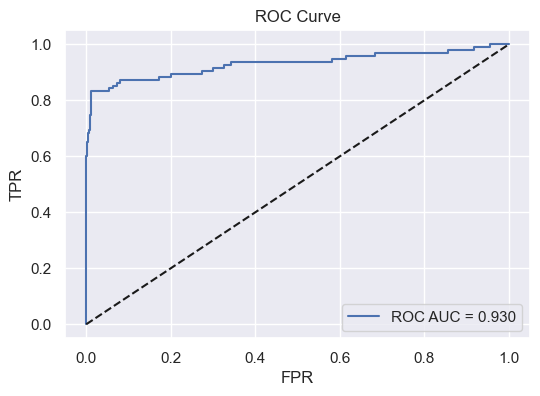

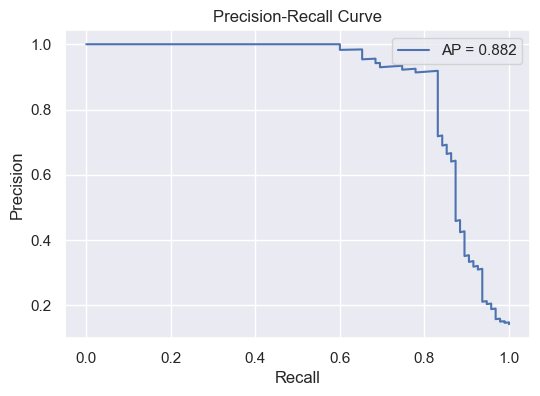

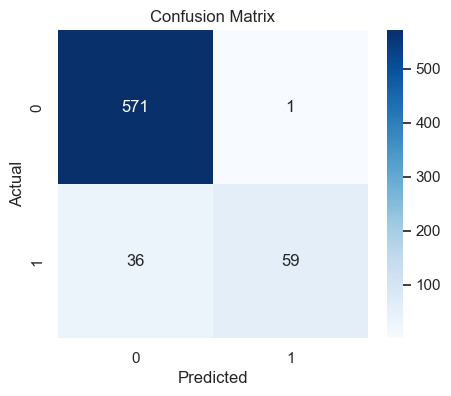

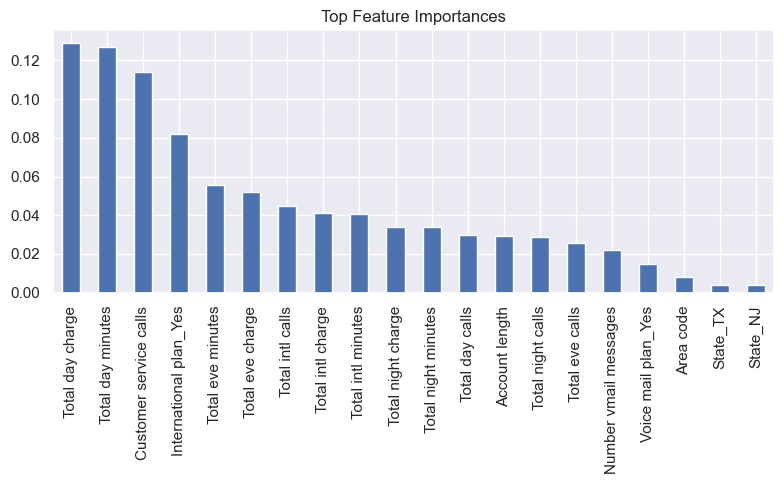

In [7]:

# ROC & PR curves, Confusion matrix, Feature importance
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt, numpy as np, pandas as pd

# Ensure 'best' exists (from previous tuning)
try:
    model = best  # tuned RF from notebook
except NameError:
    model = None

if model is not None:
    # Predict probabilities if available
    if hasattr(model, 'predict_proba'):
        proba = model.predict_proba(X_test_s)[:,1]
    else:
        # use decision function or fallback to predictions
        proba = model.predict(X_test_s)
    # ROC
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,4)); plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}'); plt.plot([0,1],[0,1],'k--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.show()
    # PR
    precision, recall, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    plt.figure(figsize=(6,4)); plt.plot(recall, precision, label=f'AP = {ap:.3f}'); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve'); plt.legend(); plt.show()
    # Confusion matrix heatmap
    preds = model.predict(X_test_s)
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(5,4)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues'); plt.title('Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()
    # Feature importance (if RF)
    try:
        imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False).head(20)
        plt.figure(figsize=(8,5)); imp.plot(kind='bar'); plt.title('Top Feature Importances'); plt.tight_layout(); plt.show()
    except Exception as e:
        print('Feature importance not available:', e)
else:
    print('No tuned model "best" found in the notebook environment. Run tuning cell first.')


<Figure size 600x400 with 0 Axes>

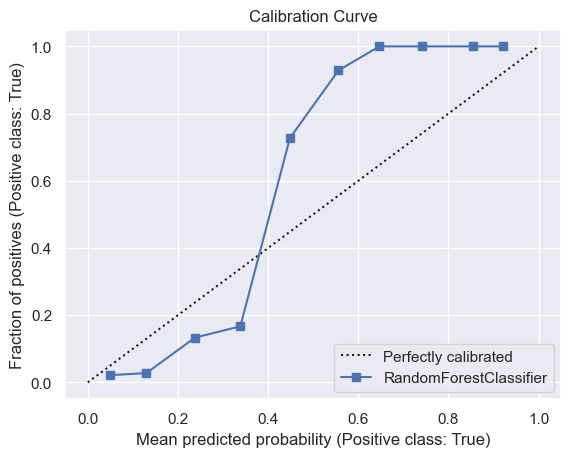

In [16]:

# : Calibration curve (requires sklearn.calibration.CalibrationDisplay)
try:
    from sklearn.calibration import CalibrationDisplay
    if model is not None and hasattr(model, 'predict_proba'):
        plt.figure(figsize=(6,4))
        CalibrationDisplay.from_estimator(model, X_test_s, y_test, n_bins=10)
        plt.title('Calibration Curve')
        plt.show()
except Exception as e:
    print('Calibration plot skipped (not available):', e)
